In [105]:
import torch
torch.manual_seed(1)
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('Names.csv')

namecol = data.iloc[:,1]
countcol = data.iloc[:,4]
total_list = {}
for name, count in zip(namecol, countcol):
    if name in total_list:
        total_list[name] += count 
    else:
        total_list[name] = count


final_list = [[name, total] for name, total in total_list.items()]


In [ ]:
final_list

In [ ]:
#randomaf normalized weights for char pair in the future
final_listx = final_list
for line in final_listx:
    line[1]=line[1]/100000
final_listx

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(namecol).lower())))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


In [120]:
namecol1 = []
block_size = 3
for line in final_listx:
    namecol1.append(line[0].lower())
import random
random.seed(42)
random.shuffle(namecol1)
n1 = int(0.8*len(namecol1))
n2 = int(0.9*len(namecol1))

Xtr, Ytr = build_dataset(namecol1[:n1])
Xdev, Ydev = build_dataset(namecol1[n1:n2])
Xte, Yte = build_dataset(namecol1[n2:])

torch.Size([565774, 3]) torch.Size([565774])
torch.Size([70758, 3]) torch.Size([70758])
torch.Size([70665, 3]) torch.Size([70665])


In [45]:
#first layer of nn
W1 = torch.randn(6,444)
b1= torch.randn(444)

In [46]:
emb.view(-1,6).shape

torch.Size([707197, 6])

In [47]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [48]:
h.shape

torch.Size([707197, 444])

In [49]:
#second layer of nn
W2 = torch.randn(444,27)
b2= torch.randn(27)

In [50]:
logits = h @ W2 + b2

In [51]:
logits.shape

torch.Size([707197, 27])

In [65]:
loss = -prob[torch.arange(prob.shape[0]),Y].log().mean()
loss

tensor(34.5041)

In [64]:
F.cross_entropy(logits,Y)

tensor(34.5041)

In [155]:
#cleaner look
#first layer of nn
W1 = torch.randn(30,444)
b1= torch.randn(444)
#second layer of nn
W2 = torch.randn(444,27)
b2= torch.randn(27)
C = torch.randn((27,10))
params = [C, W1, b1, W2, b2]


In [156]:
for p in params:
    p.requires_grad = True

In [157]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [ ]:
#forwardpass with minibatch to use full dataset
epoch = 25000
alpha = 0.05
lri = []
lossi = []
for ep in range(epoch):
    #minibatch
    ix = torch.randint(0,Xtr.shape[0],(642,))
    
    #forwardpass (with full dataset)
    emb = C[Xtr[ix]] #([707197, 3, 2])
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) #([707197, 444])
    logits = h @ W2 + b2  #([707197, 27])
    loss = F.cross_entropy(logits,Ytr[ix])
    #backwardpass
    for p in params:
        p.grad = None
    loss.backward()
    #update learning rate
   # alpha = lrs[ep]
    for p in params:
        p.data -= alpha * p.grad
    #tracking loss and learning rate
  #  lri.append(lrs[ep])
   # lossi.append(loss.item())
print(loss.item())


In [ ]:
#full model loss to compare with minibatch
emb = C[Xtr] #([707197, 3, 2])
h = torch.tanh(emb.view(-1,30) @ W1 + b1) #([707197, 444])
logits = h @ W2 + b2  #([707197, 27])
loss = F.cross_entropy(logits,Ytr)
loss

In [ ]:
#full model loss to compare with minibatch valset
emb = C[Xdev] #([707197, 3, 2])
h = torch.tanh(emb.view(-1,30) @ W1 + b1) #([707197, 444])
logits = h @ W2 + b2  #([707197, 27])
loss = F.cross_entropy(logits,Ydev)
loss

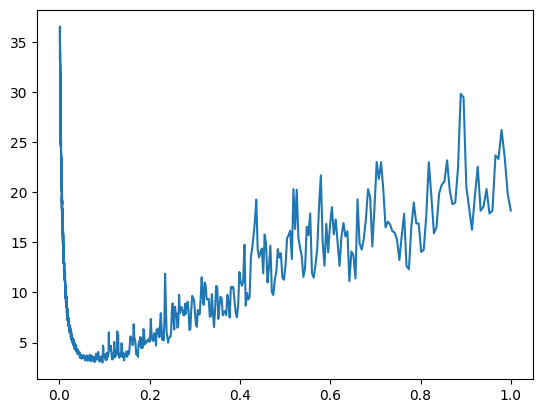

In [112]:
plt.plot(lri,lossi)

In [ ]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

In [149]:
probs[0]

tensor([0.2667, 0.0315, 0.0020, 0.0034, 0.0128, 0.1708, 0.0038, 0.0046, 0.0266,
        0.1888, 0.0055, 0.0049, 0.0612, 0.0107, 0.0200, 0.0512, 0.0010, 0.0006,
        0.0194, 0.0325, 0.0286, 0.0110, 0.0052, 0.0022, 0.0004, 0.0314, 0.0032],
       grad_fn=<SelectBackward0>)

In [150]:
probs

tensor([[0.2667, 0.0315, 0.0020, 0.0034, 0.0128, 0.1708, 0.0038, 0.0046, 0.0266,
         0.1888, 0.0055, 0.0049, 0.0612, 0.0107, 0.0200, 0.0512, 0.0010, 0.0006,
         0.0194, 0.0325, 0.0286, 0.0110, 0.0052, 0.0022, 0.0004, 0.0314, 0.0032]],
       grad_fn=<SoftmaxBackward0>)